In [5]:
import sys
sys.path.append("../")  # import path starts with src/

from sklearn.decomposition import PCA
from preprocessing.create_train_test_dicts import build_original_splits
from preprocessing.knn_preprocess import dict_to_xy
from sklearn.neighbors import KNeighborsClassifier

ds = build_original_splits()
train_split = ds['train_numeric']
test_split = ds['test_numeric']

X_train, y_train = dict_to_xy(train_split)
X_test, y_test = dict_to_xy(test_split)

pca_final = PCA(n_components=50, whiten=True, random_state=42) #found in param search pca_dim=50
pca_final.fit(X_train)

X_train_pca = pca_final.transform(X_train)
X_test_pca  = pca_final.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=8, weights="distance") #found in  param search k = 8
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)


In [6]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("======== FINAL TEST METRICS ========")
print(f"Accuracy       : {acc:.4f}")
print(f"F1 Macro       : {f1_macro:.4f}")
print(f"F1 Weighted    : {f1_weighted:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



======== FINAL TEST METRICS ========
Accuracy       : 0.4337
F1 Macro       : 0.4310
F1 Weighted    : 0.4286

Classification Report:

              precision    recall  f1-score   support

       angry       0.44      0.28      0.34       958
     disgust       0.46      0.43      0.45       111
        fear       0.42      0.31      0.36      1024
       happy       0.47      0.57      0.52      1774
     neutral       0.32      0.49      0.39      1233
         sad       0.38      0.28      0.32      1247
    surprise       0.67      0.62      0.64       831

    accuracy                           0.43      7178
   macro avg       0.45      0.43      0.43      7178
weighted avg       0.44      0.43      0.43      7178



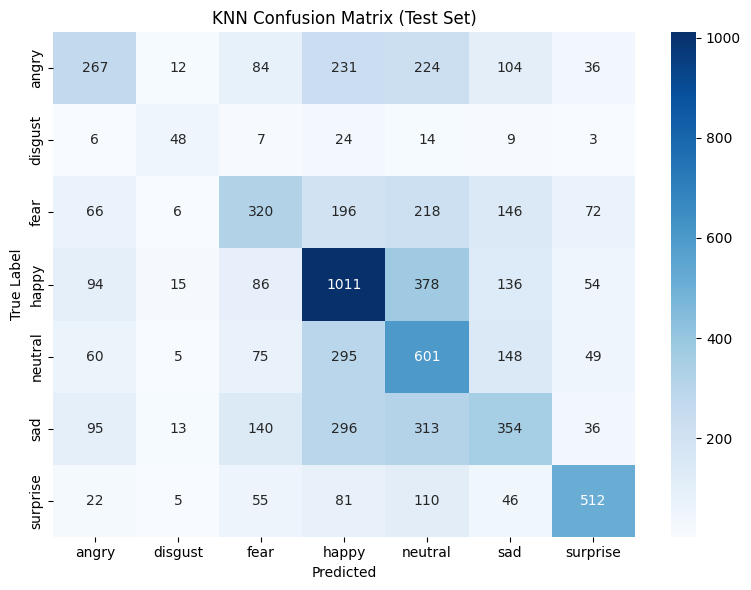

In [7]:
# ---------------------------
# Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
classes = sorted(list(set(y_test)))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()